# NLP for Large Movie Review Dataset Sentiment Analysis

In [164]:
import warnings

import re
from datetime import datetime

import pandas as pd  
import numpy as np

from bs4 import BeautifulSoup
from shutil import unpack_archive

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer

from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, concatenate, Activation, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from keras.models import load_model, Model
from keras_preprocessing.sequence import pad_sequences

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, auc, explained_variance_score, roc_curve

import pyspark as ps
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, NGram, StringIndexer, Tokenizer, VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id

import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
import os

# Path to the IMDB dataset directory
data_dir_train = "/Users/arifmathiq/AI Data Science Course/Project/train"

# List of labels (positive or negative)
labels = ['pos', 'neg']

# Create empty lists for the text data and labels
text_data_train = []
label_data_train = []

# Loop through the labels and read in the corresponding files
for label in labels:
    # Create a subdirectory path for the label
    dir_path = os.path.join(data_dir_train, label)
    
    # Loop through the files in the subdirectory
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        
        # Read in the file content
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            
        # Append the text and label to the respective lists
        text_data_train.append(text)
        label_data_train.append(label)


In [166]:
# Path to the IMDB dataset directory
data_dir_test = "/Users/arifmathiq/AI Data Science Course/Project/test"

# List of labels (positive or negative)
labels = ['pos', 'neg']

# Create empty lists for the text data and labels
text_data_test = []
label_data_test = []

# Loop through the labels and read in the corresponding files
for label in labels:
    # Create a subdirectory path for the label
    dir_path = os.path.join(data_dir_train, label)
    
    # Loop through the files in the subdirectory
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        
        # Read in the file content
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            
        # Append the text and label to the respective lists
        text_data_test.append(text)
        label_data_test.append(label)


To create a pandas DataFrame of the labels for the IMDB dataset, you can use the pd.DataFrame() constructor and pass in a dictionary that maps the review text to the corresponding label. 

In [56]:
#Create a dictionary mapping the text data to the label data
data_dict_train = {'text': text_data_train, 'label': label_data_train}
data_dict_test = {'text': text_data_test, 'label': label_data_test}

### EDA

In [57]:
# Create a pandas DataFrame from the dictionary
df_train = pd.DataFrame(data_dict_train)
df_train = df_train.rename(columns={'text': 'Review', 'label': 'Label'})
# Print the first few rows of the DataFrame
df_train.head()

,Review,Label
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos


In [58]:
df_train.shape

(25000, 2)

In [59]:
assert( df_train.shape == (25000, 2))

In [60]:
# Create a pandas DataFrame from the dictionary
df_test = pd.DataFrame(data_dict_test)
df_test = df_test.rename(columns={'text': 'Review', 'label': 'Label'})
# Print the first few rows of the DataFrame
df_test.head()

,Review,Label
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos


In [61]:
df_test.shape

(25000, 2)

In [62]:
assert( df_test.shape == (25000, 2))

### Code clean up

We will use the following function to cleanup the data

In [63]:
def clean_review(review, remove_stopwords=False):
    # Remove HTML tags
    review = BeautifulSoup(review, "lxml").get_text()
    
    # Remove "@..." mentions
    review = re.sub("@[A-Za-z0-9_]+","", review)

    # Remove URLs that start with http, https or just www
    review = re.sub("https?://[^ ]+","",review)
    review = re.sub("www.[^ ]+","",review)

    # Decode and replace unicode unrecognisable special characters with u"\ufffd"
    try:
        review = review.decode("utf-8-sig")
    except:
        pass

    # now replace u"\ufffd" with "?"
    review.replace(u"\ufffd", "?")

    # TODO: Keep or replace emoticons and exclamations, etc. with text
    
    # Remove non-letters
    review = re.sub("[^a-zA-Z]"," ", review)
    
    # Convert text to lower case and tokenize them
    words = WordPunctTokenizer().tokenize(review.lower())

    # Remove stop words (false by default)
    if remove_stopwords:
        words = [w for w in words if w not in set(stopwords.words("english"))]

    # Join back the list of words
    cleaned_review = (" ".join(words)).strip()

    return cleaned_review

Let's test the above function on an example with all the patterns that it removes:

In [64]:
test_example = "Story of a man who has unnatural feelings for a pig." + \
"Starts out with a opening scene that is a terrific example of absurd comedy." 
print(clean_review(test_example, False))

story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy


We will now clean up the dataset in two different ways. We will also time it so that we will see which one is more efficient.

Heads up: The following code takes about 10 seconds to run

In [65]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

# The following code is identical to the above loop, but is more fancy
df_train["Review"] = df_train["Review"].apply(lambda x: clean_review(x))

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2023-03-14 18:42:19


/Users/arifmathiq/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


End : 2023-03-14 18:42:31
This step took 12.164 seconds


In [66]:
df_train["Review"].head(10)

0    for a movie that gets no respect there sure ar...
1    bizarre horror movie filled with famous faces ...
2    a solid if unremarkable film matthau as einste...
3    it s a strange feeling to sit alone in a theat...
4    you probably all already know this by now but ...
5    i saw the movie with two grown children althou...
6    you re using the imdb you ve given some hefty ...
7    this was a good film with a powerful message o...
8    made after quartet was trio continued the qual...
9    for a mature man to admit that he shed a tear ...
Name: Review, dtype: object

Let's now clean the test set:

In [67]:
df_test["Review"] = df_test["Review"].apply(lambda x: clean_review(x))
df_test["Review"].head(20)

0     for a movie that gets no respect there sure ar...
1     bizarre horror movie filled with famous faces ...
2     a solid if unremarkable film matthau as einste...
3     it s a strange feeling to sit alone in a theat...
4     you probably all already know this by now but ...
5     i saw the movie with two grown children althou...
6     you re using the imdb you ve given some hefty ...
7     this was a good film with a powerful message o...
8     made after quartet was trio continued the qual...
9     for a mature man to admit that he shed a tear ...
10    aileen gonsalves my girlfriend is in this film...
11    jonathan demme s directorial debut for roger c...
12    when i rented this movie to watch it i knew th...
13    it s hard to say sometimes why exactly a film ...
14    yes this gets the full ten stars it s plain as...
15    hello this movie is well okay just kidding its...
16    this is a film that was very well done i had h...
17    a typical romp through cheech and chong s 

Let's save the results so that we can use them in the future, or start from here in future iterations to avoid the huge learning time above.

In [68]:
!rm -rf Large_Movie_Review_sentiments.train.csv
Large_Movie_Review_sentiments_train_filename = "Large_Movie_Review_sentiments.train.csv"
df_train.to_csv(Large_Movie_Review_sentiments_train_filename, index=False, quoting=3, 
                quotechar='', escapechar='\\', encoding='utf-8')

In [69]:
!rm -rf Large_Movie_Review_sentiments.test.csv
Large_Movie_Review_sentiments_test_filename = "Large_Movie_Review_sentiments.test.csv"
df_train.to_csv(Large_Movie_Review_sentiments_test_filename, index=False, quoting=3, 
                quotechar='', escapechar='\\', encoding='utf-8')

## Models

### Scikit Learn Random Forest Classifier

For this model we will use the df_train and df_test data we created and wrote to their respective files above. We can directly use them since they are already in memory, but just for the sake of modularity and completeness, we will start from scratch and read them from the files into pandas dataframes:

In [167]:
df_train_new = pd.read_csv(Large_Movie_Review_sentiments_train_filename, dtype=object, quoting=3, 
                           quotechar='', escapechar='\\', encoding='utf-8')
df_test_new = pd.read_csv(Large_Movie_Review_sentiments_test_filename, dtype=object, quoting=3, 
                          quotechar='', escapechar='\\', encoding='utf-8')

In [168]:
df_train_new.shape, df_test_new.shape

((25000, 2), (25000, 2))

Let's drop the rows with empty tweets, but let's first check the sizes of the dataframes:

In [169]:
df_train_new.dropna(axis=0, inplace=True)
df_test_new.dropna(axis=0, inplace=True);

In [170]:
df_train_new.shape, df_test_new.shape

((25000, 2), (25000, 2))

In [171]:
df_train_new.isnull().sum()

Review    0
Label     0
dtype: int64

In [172]:
df_test_new.isnull().sum()

Review    0
Label     0
dtype: int64

In [173]:
X_train = df_train_new["Review"]
Y_train = df_train_new["Label"]
X_test = df_test_new["Review"]
Y_test = df_test_new["Label"]


In [174]:
Y_train.value_counts()

pos    12500
neg    12500
Name: Label, dtype: int64

In [175]:
Y_test.value_counts()

pos    12500
neg    12500
Name: Label, dtype: int64

In [176]:
# Create a bag of words from the cleaned up reviews
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = stopwords.words("english"),   \
                             max_features = 5000)

# Fits the model and learn the vocabulary; then transforms the data into feature vectors
X_train_features = vectorizer.fit_transform(X_train)
X_train_features

<25000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1974868 stored elements in Compressed Sparse Row format>

In [177]:
# Create a Random Forest classifier with 100 trees

rfc = RandomForestClassifier(n_estimators = 100)

We will do the training right now, but because we are not using spark for this model, it will take some time (approximately 1 minutes). 

In [178]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

# Fit the Random Forest classifier to the training set, using the bag of words as
# features and the sentiment labels as the response variable
rfc.fit(X_train_features, Y_train)

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2023-03-14 21:07:15
End : 2023-03-14 21:08:28
This step took 72.669 seconds


Let's first calculate the accuracy on the exact subset of the training set we used for training:

In [179]:
X_train_features = vectorizer.transform(X_train)
Y_train_pred = rfc.predict(X_train_features)
acc_score = accuracy_score(Y_train, Y_train_pred)
print("accuracy_score={}".format(acc_score))

accuracy_score=0.99996


Then on the rest of the training set, that we excluded during training (to reduce the runtime):



In [180]:
X_train_features_rest = vectorizer.transform(X_train)
Y_train_pred_rest = rfc.predict(X_train_features_rest)
acc_score = accuracy_score(Y_train, Y_train_pred_rest)
print("accuracy_score={}".format(acc_score))

accuracy_score=0.99996


And finally, on the independent test set:

In [181]:
# transform and predict the test set
X_test_features = vectorizer.transform(X_test)
Y_test_pred = rfc.predict(X_test_features)
acc_score = accuracy_score(Y_test, Y_test_pred)
print("accuracy_score={}".format(acc_score))

accuracy_score=0.99996


In [182]:
Yhat_rf = rfc.predict_proba(X_test_features)
fpr, tpr, threshold = roc_curve(df_test_new["Label"].apply(lambda y: 0 if y=="neg" else 1), Yhat_rf[:,1])
roc_auc = auc(fpr, tpr)
print("AUC={}".format(roc_auc))

AUC=0.9999999968


### Scikit Learn Logistic Regression with tf-idf

In [183]:
X_train = df_train_new["Review"]
Y_train = df_train_new["Label"]
X_test = df_test_new["Review"]
Y_test = df_test_new["Label"]


In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


You can then use Scikit Learn's LogisticRegression class to train a logistic regression model on the tf-idf features.



In [185]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

Here is this models accuracy score on the train set:

In [186]:
lr.score(X_train, Y_train)

0.92568

Here is this models accuracy score on the test set:

In [187]:
lr.score(X_test, Y_test)

0.92568

It looks like the accuracy of the Logistic Regression model was NOT much better than the Random Forest Model.

Let's create the prediction probabilities for the test set (which we will need while creating the ROC curve):

In [188]:
Yhat_lr = lr.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(df_test_new["Label"].apply(lambda y: 0 if y=="neg" else 1), Yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
print("AUC={}".format(roc_auc))

AUC=0.9786514303999999


You can evaluate the performance of the logistic regression model on the test set using Scikit Learn's classification_report function, which will calculate precision, recall, and F1-score for each class, as well as overall accuracy.

In [189]:
from sklearn.metrics import classification_report

y_pred = lr.predict(X_test)
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

         neg       0.93      0.92      0.93     12500
         pos       0.92      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



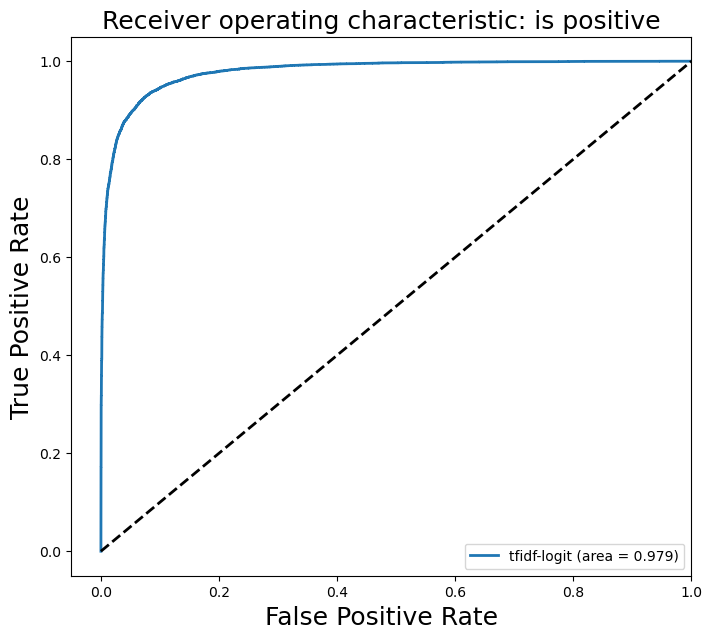

In [190]:
Yhat_lr = lr.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(df_test_new["Label"].apply(lambda y: 0 if y=="neg" else 1), Yhat_lr[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Here are the results:

<TABLE>
<TR> <TH> Model
     <TH> Train Set Accuracy
     <TH> Test Set Accuracy
     <TH> AUC (ROC)

<TR> <TD> <CENTER> Scikit Learn Random Forest </CENTER>
     <TD> <CENTER> 0.99 % </CENTER>
     <TD> <CENTER> 0.99 % </CENTER>
     <TD> <CENTER> 0.99 </CENTER>
   
<TR> <TD> <CENTER> Logistic Regression with tf-idf </CENTER>
     <TD> <CENTER> 0.92 % </CENTER>
     <TD> <CENTER> 0.92 % </CENTER>
     <TD> <CENTER> 0.97 </CENTER>

In [201]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('spark://<host>:<port>').appName('MyApp').getOrCreate()


23/03/14 21:18:42 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:67)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.ja

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.NoClassDefFoundError: Could not initialize class org.apache.spark.storage.StorageUtils$
	at org.apache.spark.storage.BlockManagerMasterEndpoint.<init>(BlockManagerMasterEndpoint.scala:110)
	at org.apache.spark.SparkEnv$.$anonfun$create$9(SparkEnv.scala:348)
	at org.apache.spark.SparkEnv$.registerOrLookupEndpoint$1(SparkEnv.scala:287)
	at org.apache.spark.SparkEnv$.create(SparkEnv.scala:336)
	at org.apache.spark.SparkEnv$.createDriverEnv(SparkEnv.scala:191)
	at org.apache.spark.SparkContext.createSparkEnv(SparkContext.scala:277)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:460)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:67)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: java.lang.ExceptionInInitializerError: Exception java.lang.IllegalAccessError: class org.apache.spark.storage.StorageUtils$ (in unnamed module @0x4a16581b) cannot access class sun.nio.ch.DirectBuffer (in module java.base) because module java.base does not export sun.nio.ch to unnamed module @0x4a16581b [in thread "Thread-2"]
	at org.apache.spark.storage.StorageUtils$.<init>(StorageUtils.scala:213)
	at org.apache.spark.storage.StorageUtils$.<clinit>(StorageUtils.scala)
	... 19 more


In [208]:
tar -xvf spark-3.3.2-bin-hadoopx.3.tgz


SyntaxError: invalid syntax (823049666.py, line 1)

### Load the data for modeling on Spark


In [204]:
try:
    sc = ps.SparkContext()
    sqlContext = SQLContext(sc)
    print("Created a new SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

23/03/14 21:33:20 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:67)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.ja

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.NoClassDefFoundError: Could not initialize class org.apache.spark.storage.StorageUtils$
	at org.apache.spark.storage.BlockManagerMasterEndpoint.<init>(BlockManagerMasterEndpoint.scala:110)
	at org.apache.spark.SparkEnv$.$anonfun$create$9(SparkEnv.scala:348)
	at org.apache.spark.SparkEnv$.registerOrLookupEndpoint$1(SparkEnv.scala:287)
	at org.apache.spark.SparkEnv$.create(SparkEnv.scala:336)
	at org.apache.spark.SparkEnv$.createDriverEnv(SparkEnv.scala:191)
	at org.apache.spark.SparkContext.createSparkEnv(SparkContext.scala:277)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:460)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:67)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: java.lang.ExceptionInInitializerError: Exception java.lang.IllegalAccessError: class org.apache.spark.storage.StorageUtils$ (in unnamed module @0x4a16581b) cannot access class sun.nio.ch.DirectBuffer (in module java.base) because module java.base does not export sun.nio.ch to unnamed module @0x4a16581b [in thread "Thread-2"]
	at org.apache.spark.storage.StorageUtils$.<init>(StorageUtils.scala:213)
	at org.apache.spark.storage.StorageUtils$.<clinit>(StorageUtils.scala)
	... 19 more


Let's load the training dataset

In [196]:
spark_df_train = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(Large_Movie_Review_sentiments_train_filename)

NameError: name 'sqlContext' is not defined

In [197]:
spark_df_train = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(Large_Movie_Review_sentiments_train_filename)

NameError: name 'sqlContext' is not defined